In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
import plotnine as p9
import seaborn as sns
from tqdm import tqdm_notebook

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, mark_sentence

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

In [4]:
CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])

In [5]:
def tag_sentence(x):
    candidates=(
        session
        .query(CompoundGene)
        .filter(CompoundGene.id.in_(x.candidate_id.astype(int).tolist()))
        .all()
    )
    tagged_sen=[
         " ".join(
             mark_sentence(
                candidate_to_tokens(cand), 
                [
                        (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                        (cand[1].get_word_start(), cand[1].get_word_end(), 2)
                ]
            )
         )
        for cand in candidates
    ]

    return tagged_sen

In [6]:
spreadsheet_names = {
    #'train': '../data/sentences/sentence_labels_train.xlsx',
    'dev': '../data/sentences/sentence_labels_dev.xlsx',
    'test': '../data/sentences/sentence_labels_test.xlsx'
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_cbg")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [8]:
dev_predictions_df = pd.read_table("input/calibrated_tune.tsv")
dev_predictions_df.head(2)

,uncal,cal,candidate_id
0,0.072222,0.048975,50527
1,0.080804,0.055989,51441


In [9]:
dev_labels = pd.read_csv("../disc_model_experiment/input/cbg_dev_labels.tsv", sep="\t")
dev_labels.head(2)

,candidate_id,curated_cbg
0,50527,0.0
1,51441,0.0


In [10]:
total_candidates_df = pd.read_csv("../dataset_statistics/results/all_cbg_candidates.tsv.xz", sep="\t")
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DB00117,L-Histidine,NaN,0,1,1,0.37753,6,1.0,0.0,10.0,94389805,"Thus, as the assessment of protein glycosylati...",114,33517095
1,1,A1BG,DB00143,Glutathione,NaN,0,1,1,0.30352,6,1.0,1.0,2.0,83523801,Similar observations were made in T98 glioma c...,34,28913100


In [11]:
confidence_score_df = (
    total_candidates_df
    [["name", "gene_symbol", "text", "candidate_id"]]
    .merge(dev_predictions_df, on="candidate_id")
    .merge(dev_labels, on="candidate_id")
    .sort_values("candidate_id")
    .assign(text=lambda x: tag_sentence(x))
    .sort_values("cal")
)
confidence_score_df.head(2)

,name,gene_symbol,text,candidate_id,uncal,cal,curated_cbg
234,Estriol,LGALS1,[ diagnostic value of serial determination of ...,110845,0.009561,0.004535,0.0
297,D-Leucine,POMC,cross-reactivities of ~~[[1 leucine-enkephalin...,1180719,0.010828,0.005244,1.0


In [12]:
(
    confidence_score_df
    .head(10)
    .sort_values("cal", ascending=False)
    .drop(["candidate_id", "curated_cbg"], axis=1)
    .round(3)
    .to_csv("output/bottom_ten_high_confidence_scores.tsv", sep="\t", index=False)
)

In [13]:
(
    confidence_score_df
    .tail(10)
    .sort_values("cal", ascending=False)
    .drop(["candidate_id", "curated_cbg"], axis=1)
    .round(3)
    .to_csv("output/top_ten_high_confidence_scores.tsv", sep="\t", index=False)
)

In [14]:
from sklearn.calibration import calibration_curve
cnn_y, cnn_x = calibration_curve(
    confidence_score_df.curated_cbg, 
    confidence_score_df.uncal, 
    n_bins=10
)

all_cnn_y, all_cnn_x = calibration_curve(
    confidence_score_df.curated_cbg, 
    confidence_score_df.cal, 
    n_bins=10
)

calibration_df = pd.DataFrame.from_records(
    list(map(lambda x: {"predicted":x[0], "actual": x[1], "model_calibration":'before'}, zip(cnn_x, cnn_y)))
    + list(map(lambda x: {"predicted":x[0], "actual": x[1], "model_calibration":'after'}, zip(all_cnn_x, all_cnn_y)))
)
calibration_df.to_csv("output/cbg_calibration.tsv", sep="\t", index=False)

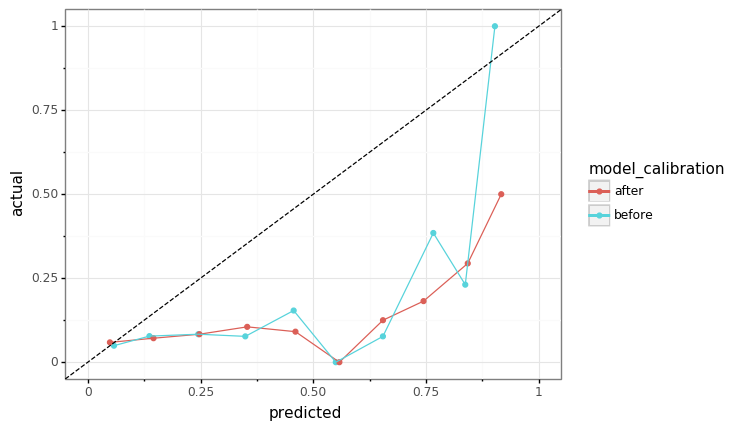

<ggplot: (-9223363246614766311)>

In [15]:
(
    p9.ggplot(calibration_df, p9.aes(x="predicted", y="actual", color="model_calibration"))
    + p9.geom_point()
    + p9.geom_line(p9.aes(group="factor(model_calibration)"))
    + p9.geom_abline(intercept=0, slope=1, linetype='dashed')
    + p9.scale_y_continuous(limits=[0,1])
    + p9.scale_x_continuous(limits=[0,1])
    + p9.theme_bw()
)